# DDPM V2

In [1]:
#|default_exp accel

In [2]:
import random
import fastcore.all as fc
from functools import partial
import matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import logging

from datasets import load_dataset

import torch
from torch import distributions, nn, tensor, optim
from torch.nn import init
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

from diffusers import UNet2DModel

from minai.conv import def_device
from minai.datasets import inplace, show_images, show_image
from minai.learner import MetricsCB, DeviceCB, ProgressCB, DataLoaders, Learner, TrainLearner, SingleBatchCB, MomentumLearner, lr_find, Callback, to_cpu, TrainCB
from minai.activations import Hooks
from minai.init import conv, GeneralRelu, init_weights, ActivationStats, set_seed, BatchTransformCB
from minai.sgd import BatchSchedCB, BaseSchedCB
from minai.resnet import ResBlock

set_seed(42)

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.8) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [44]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [45]:
x, y = 'image', 'label'
name = 'anubhavmaity/notMNIST'
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
})

In [46]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32, 32)) for o in b[x]]

In [47]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([6, 9, 4, 8, 4, 0, 3, 3, 5, 2]))

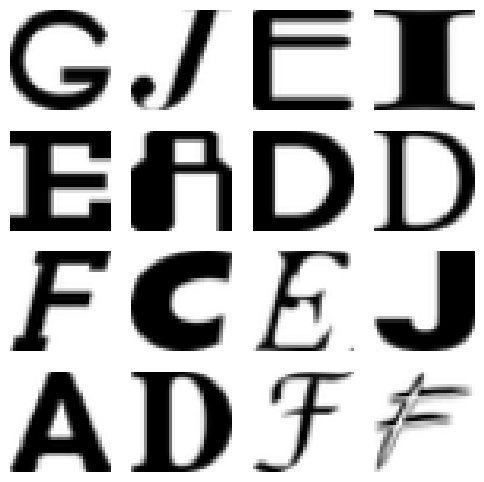

In [48]:
show_images(xb[:16], imsize=1.5)

In [49]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

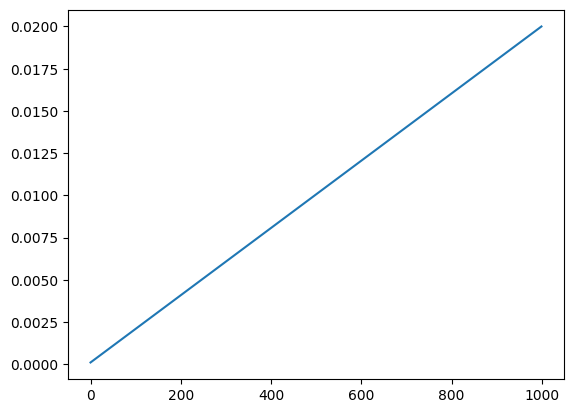

In [50]:
plt.plot(beta)

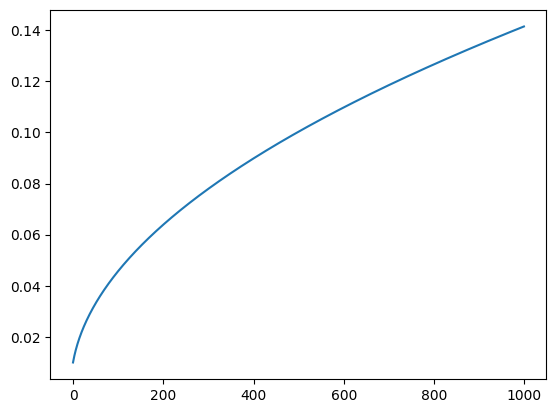

In [51]:
plt.plot(sigma)

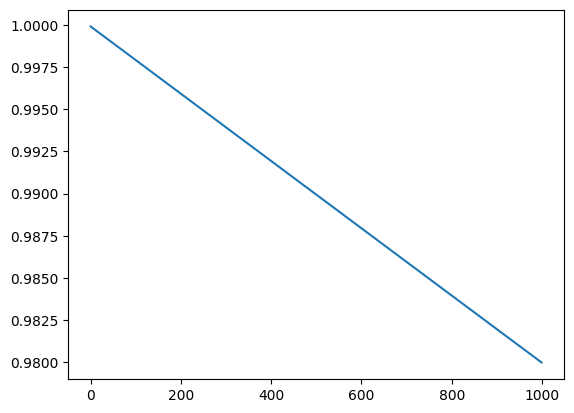

In [52]:
plt.plot(1 - beta)

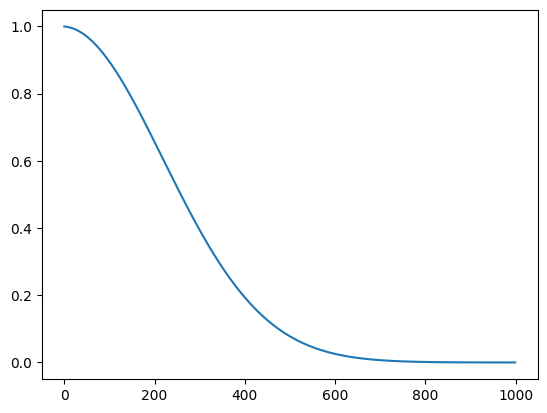

In [53]:
plt.plot(alphabar)

In [54]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt() * x0 + (1 - alphabar_t).sqrt() * epsilon
    return (xt, t.to(device)), epsilon

In [14]:
(xt, t), epsilon = noisify(xb[:25], alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295, 567, 706, 749, 876,  73, 111, 899,
        213, 541])

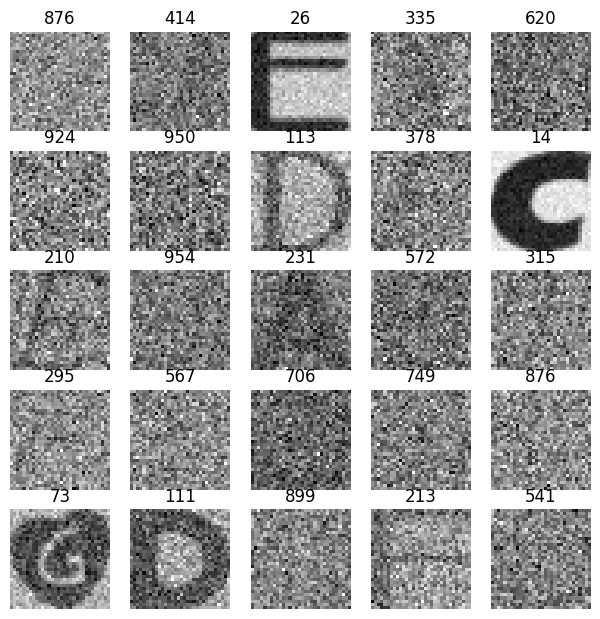

In [15]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [16]:
from diffusers import UNet2DModel

In [17]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alphabar_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        betabar_t = 1 - alphabar[t]
        betabar_t1 = 1 - alphabar_t1
        x_0_hat = ((x_t - betabar_t.sqrt() * learn.model((x_t, t_batch)))/ alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * alphabar_t1.sqrt() * (1 - alpha[t])/betabar_t + x_t * alpha[t].sqrt() * betabar_t1 / betabar_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [18]:
@torch.no_grad()
def sample2(model, sz, n_steps, alpha, alphabar, sigma):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        noise_pred = learn.model((x_t, t_batch))
        
        term1 = (x_t - ((1 - alpha_t) / (1 - alphabar_t).sqrt()) * noise_pred)
        term2 = sigma[t] * z
        
        x_t = 1 / alpha_t.sqrt() * term1 + term2
        preds.append(x_t.cpu())
    return preds

In [19]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta 
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.alphabar)
    def sample(self, model, sz): 
        return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps)
    def sample2(self, model, sz):     
        return sample2(model, sz, self.n_steps, self.alpha, self.alphabar, self.sigma)

In [20]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [21]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min = 0.0001, beta_max = 0.01)

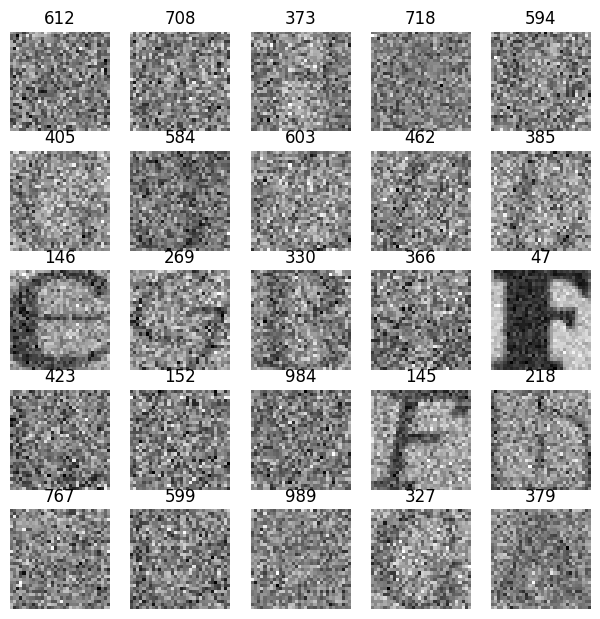

In [22]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])

(xt, t), epsilon = learn.batch
show_images(xt[:25], titles = fc.map_ex(t[:25], '{}'), imsize=1.5)

In [22]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [23]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [23]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)
    
    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()
    
    model.conv_out.weight.data.zero_()

In [25]:
init_ddpm(model)

In [27]:
opt_func = partial(optim.Adam, eps=1e-5)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.338,0,True
0.054,0,False
0.041,1,True
0.039,1,False
0.032,2,True
0.034,2,False
0.029,3,True
0.029,3,False
0.027,4,True
0.027,4,False


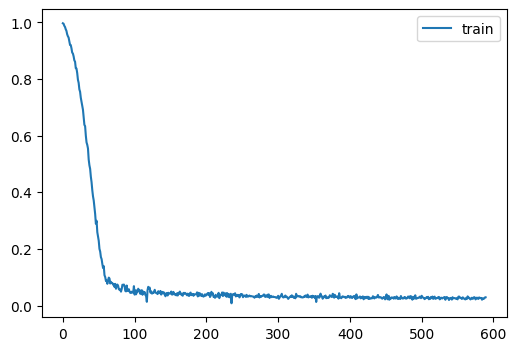

In [27]:
learn.fit(epochs)

In [28]:
mdl_path = fc.Path('models')
mdl_path.mkdir(exist_ok=True)

In [29]:
torch.save(learn.model, mdl_path/'notMnist_ddpm2.pkl')

## Sampling

In [30]:
learn.model = torch.load(mdl_path/'notMnist_ddpm2.pkl')

In [31]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

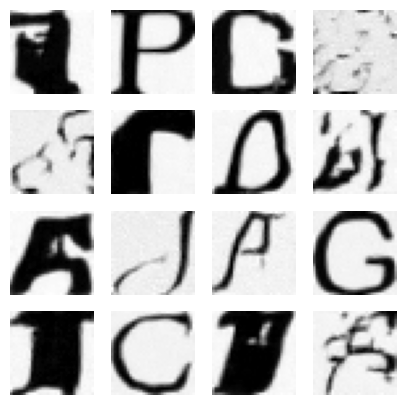

In [32]:
show_images(samples[-1], figsize=(5, 5))

In [33]:
samples2 = ddpm_cb.sample2(learn.model, (16, 1, 32, 32))

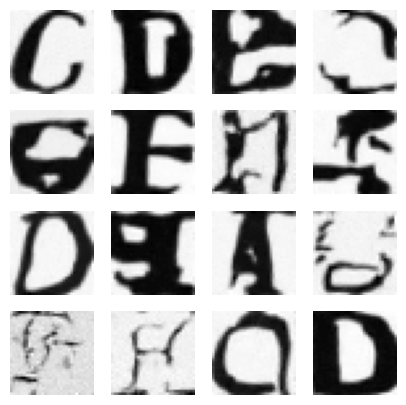

In [34]:
show_images(samples2[-1], figsize=(5, 5))

## Mixed Precision

In [55]:
bs = 512

In [56]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
           [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
           [0.00, 0.00, 0.00,  ..., 0.01, 0.00, 0.00],
           ...,
           [0.00, 0.00, 0.00,  ..., 0.01, 0.00, 0.00],
           [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
           [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00]]],
 
 
         [[[0.00, 0.00, 0.00,  ..., 0.14, 0.14, 0.12],
           [0.00, 0.00, 0.00,  ..., 0.03, 0.03, 0.02],
           [0.00, 0.00, 0.00,  ..., 0.01, 0.00, 0.00],
           ...,
           [0.05, 0.49, 0.84,  ..., 0.00, 0.00, 0.00],
           [0.00, 0.08, 0.51,  ..., 0.00, 0.00, 0.00],
           [0.01, 0.00, 0.04,  ..., 0.00, 0.00, 0.00]]]]),
 'label': tensor([6, 9])}

In [57]:
def collate_ddpm(b): return noisify(default_collate(b)[x], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [58]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [59]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order + 10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()
    
    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()
    
    def after_loss(self, learn):
        self.autocast.__exit__(None, None, None)
    
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()
    
    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [65]:
lr = 6e-3
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), TrainCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.701,0,True
0.182,0,False
0.077,1,True
0.053,1,False
0.039,2,True
0.035,2,False
0.032,3,True
0.028,3,False
0.028,4,True
0.029,4,False


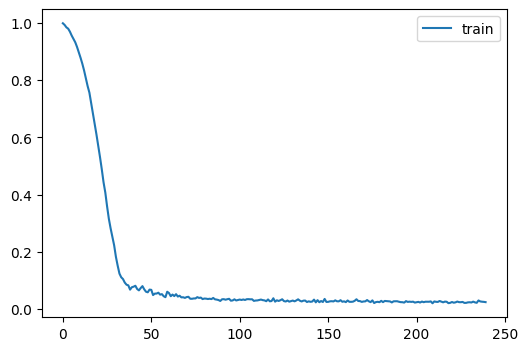

In [66]:
learn.fit(epochs)

## Accelerate

`pip install accelerate` before running this section

In [ ]:
from accelerate import Accelerator

In [ ]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order + 10
    
    def __init__(self, n_inp=1, mixed_precision='fp16'):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
    
    def before_fit(self, learn):
        learn.model, learn.opt, learn.dls.train, learn.dls.valid = self.acc.prepare(learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def backward(self, learn):  self.acc.backward(learn.loss)

In [ ]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt() * x0 + (1 - alphabar_t).sqrt() * epsilon
    return xt, t.to(device), t

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)